# Making Dataset For GRU-ODE-Bayes (by fujimori)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
from datetime import timedelta
import numpy as np

from tqdm import tqdm
import time

file_path="D:/mimic_iii/csv/"
outfile_path="D:/mimic_iii/clean_data/"

In [2]:
complete_tensor=pd.read_csv(outfile_path+"complete_tensor.csv") #Full data

In [3]:
if "Unnamed: 0" in complete_tensor.columns:
    complete_tensor=complete_tensor.drop("Unnamed: 0",axis=1)
complete_tensor.head()

,UNIQUE_ID,LABEL_CODE,TIME_STAMP,VALUENUM,MEAN,STD,VALUENORM
0,15164,0,0.0,15.0,14.332368,3.957156,0.168715
1,15164,0,26.0,12.0,14.332368,3.957156,-0.589405
2,15164,0,59.0,10.0,14.332368,3.957156,-1.094819
3,15164,1,0.0,25.0,23.683532,4.551461,0.289241
4,15164,1,26.0,25.0,23.683532,4.551461,0.289241


In [4]:
complete_tensor=complete_tensor.sort_values(["UNIQUE_ID","TIME_STAMP"])

In [5]:
complete_tensor

,UNIQUE_ID,LABEL_CODE,TIME_STAMP,VALUENUM,MEAN,STD,VALUENORM
812875,0,0,0.0,18.0,14.332368,3.957156,0.926835
812879,0,1,0.0,22.0,23.683532,4.551461,-0.369888
812885,0,3,0.0,106.0,105.072921,6.552307,0.141489
812889,0,4,0.0,1.1,1.349956,1.445214,-0.172954
812894,0,5,0.0,98.0,135.362454,91.375215,-0.408890
...,...,...,...,...,...,...,...
16819,21249,62,91.0,5.0,114.904780,122.628835,-0.896239
16817,21249,75,92.0,35.0,73.378317,48.177887,-0.796596
16821,21249,82,92.0,2300.0,574.522817,606.103838,2.846834
16818,21249,75,93.0,35.0,73.378317,48.177887,-0.796596


## 記録が1つでもある時刻に対して、96変数についてマスクの作成含め処理をしていく

In [6]:
# 患者毎に記録がある時刻の総数
bin_sum=0
for id in tqdm(list(complete_tensor["UNIQUE_ID"].unique())):
    bin_sum+=complete_tensor[complete_tensor["UNIQUE_ID"]==id]["TIME_STAMP"].nunique()


100%|██████████| 21250/21250 [00:51<00:00, 408.94it/s]


In [7]:
bin_sum

552327

bin_sum=1043381

In [8]:
# (ID,TIME)+{val0-95,mask0-95}を記録するnumpy配列を作成
val_array=np.zeros((bin_sum,2+96))
mask_array=np.zeros((bin_sum,2+96))
# pd.DataFrame(val_array)

In [9]:
import random
random.seed(0)

In [10]:
# a=[1,2,3,4,5]
# for i in random.sample(a,len(a)):
#     print(i)

In [11]:
# UNIQUE_IDの集合を得る,これをrandom.sampleでシャッフルしてから編集する
# randomはlist対象なのでndarray->listにする
groups=list(complete_tensor["UNIQUE_ID"].unique())

In [12]:
# UNIQUE_ID毎に1時刻ずつ記録してある変数を横に展開していく、マスクも記録
# 60binだと300万行あるので気長に(10^7)
# 

spenttime=[] # 実行時間記録
row_idx=0
sample_id=0

# テスト用
# sampling=random.sample(groups,10)

# 全データ用
sampling=random.sample(groups,len(groups))

for unique_id in tqdm(sampling):
    start=time.time()
    time_stamps=complete_tensor[complete_tensor["UNIQUE_ID"]==unique_id]["TIME_STAMP"].unique()
    for time_stamp in time_stamps:
        sample_time_df=complete_tensor[(complete_tensor["UNIQUE_ID"]==unique_id) & (complete_tensor["TIME_STAMP"]==time_stamp)]
        val_array[row_idx,0]=sample_id
        val_array[row_idx,1]=time_stamp
        mask_array[row_idx,0]=sample_id
        mask_array[row_idx,1]=time_stamp
        for code,valnum in zip(sample_time_df["LABEL_CODE"],sample_time_df["VALUENORM"]):
            val_array[row_idx,code+2]=valnum
            mask_array[row_idx,code+2]=1
        row_idx+=1
    sample_id+=1
    elapsed_time = time.time() - start
    spenttime.append(elapsed_time)

100%|██████████| 21250/21250 [1:05:14<00:00,  5.43it/s]


(array([8236., 5070., 1657., 1081., 1102., 1334., 1145.,  826.,  497.,
         302.]),
 array([0.01599932, 0.0838994 , 0.15179949, 0.21969957, 0.28759966,
        0.35549974, 0.42339983, 0.49129992, 0.5592    , 0.62710009,
        0.69500017]),
 <BarContainer object of 10 artists>)

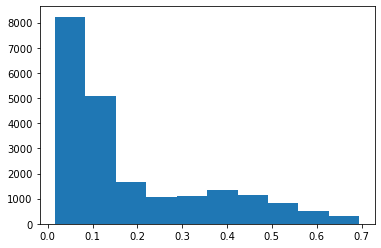

In [13]:
plt.hist(spenttime)

In [14]:
# sampling=[3,7,1,2,5,4,6]
sample_unique_id_dict=dict(zip(range(len(sampling)),sampling))
sample_unique_id_dict

{0: 12623,
 1: 13781,
 2: 1326,
 3: 8484,
 4: 16753,
 5: 15922,
 6: 13268,
 7: 9938,
 8: 15617,
 9: 11732,
 10: 19116,
 11: 7157,
 12: 16537,
 13: 4563,
 14: 9235,
 15: 4579,
 16: 3107,
 17: 20262,
 18: 8208,
 19: 17451,
 20: 19723,
 21: 4815,
 22: 10162,
 23: 3236,
 24: 2416,
 25: 10819,
 26: 15471,
 27: 18343,
 28: 3299,
 29: 11593,
 30: 14226,
 31: 10361,
 32: 20017,
 33: 20985,
 34: 6700,
 35: 18105,
 36: 15630,
 37: 14506,
 38: 17083,
 39: 8535,
 40: 2040,
 41: 17979,
 42: 460,
 43: 3056,
 44: 13068,
 45: 20488,
 46: 37,
 47: 20050,
 48: 16173,
 49: 10916,
 50: 7992,
 51: 10656,
 52: 2063,
 53: 6260,
 54: 18596,
 55: 7264,
 56: 7818,
 57: 4669,
 58: 17792,
 59: 14679,
 60: 2988,
 61: 2636,
 62: 10487,
 63: 16644,
 64: 16032,
 65: 3573,
 66: 9877,
 67: 18063,
 68: 9538,
 69: 4089,
 70: 17938,
 71: 10903,
 72: 17704,
 73: 6658,
 74: 19765,
 75: 17931,
 76: 19255,
 77: 9425,
 78: 14581,
 79: 3002,
 80: 19539,
 81: 12612,
 82: 10388,
 83: 18862,
 84: 7933,
 85: 9513,
 86: 6025,
 87: 6

In [15]:
import pickle

def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

In [16]:
# UNIQUE_IDとsample_idの接続用dictionaryの保存
# ダンプ
pickle_dump(sample_unique_id_dict, outfile_path+'sample_unique_id_dict.pickle')

In [17]:
# ロード
print(pickle_load( outfile_path+'sample_unique_id_dict.pickle')) 

 19769: 2530, 19770: 11451, 19771: 10303, 19772: 7682, 19773: 12252, 19774: 12384, 19775: 12364, 19776: 9195, 19777: 10489, 19778: 13414, 19779: 8931, 19780: 14485, 19781: 11690, 19782: 12477, 19783: 18879, 19784: 2339, 19785: 11367, 19786: 15058, 19787: 12002, 19788: 14772, 19789: 17204, 19790: 3809, 19791: 1915, 19792: 4608, 19793: 7905, 19794: 17223, 19795: 9060, 19796: 9524, 19797: 5138, 19798: 19885, 19799: 3901, 19800: 20035, 19801: 5449, 19802: 8695, 19803: 3713, 19804: 17980, 19805: 4206, 19806: 12528, 19807: 513, 19808: 396, 19809: 13851, 19810: 20944, 19811: 19623, 19812: 15853, 19813: 5479, 19814: 5091, 19815: 4534, 19816: 12981, 19817: 8853, 19818: 5164, 19819: 47, 19820: 4992, 19821: 11044, 19822: 3283, 19823: 9008, 19824: 13613, 19825: 2295, 19826: 1188, 19827: 15226, 19828: 11461, 19829: 11798, 19830: 12937, 19831: 11707, 19832: 7558, 19833: 1821, 19834: 13628, 19835: 8785, 19836: 9055, 19837: 18118, 19838: 10947, 19839: 19294, 19840: 11168, 19841: 20857, 19842: 15419, 1

In [18]:
np.save(outfile_path+'val_array',val_array)
np.save(outfile_path+'mask_array',mask_array)

In [19]:
# np.savetxt(outfile_path+'val_array.csv', val_array[0:1000,:], delimiter=',' ,)

In [20]:
# np.array(spenttime).mean()*23000/3600

In [21]:
# val_array.shape

In [22]:
val_columns=["ID","Time"]+["Value_"+str(i) for i in range(96)]
mask_columns=["ID","Time"]+["Mask_"+str(i) for i in range(96)]

In [23]:
print(val_columns[0:3])
print(mask_columns[0:3])

['ID', 'Time', 'Value_0']
['ID', 'Time', 'Mask_0']


In [24]:
val_df=pd.DataFrame(data=val_array,columns=val_columns,dtype='float')
val_df.head()

,ID,Time,Value_0,Value_1,Value_2,Value_3,Value_4,Value_5,Value_6,Value_7,...,Value_86,Value_87,Value_88,Value_89,Value_90,Value_91,Value_92,Value_93,Value_94,Value_95
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,12.0,0.000000,0.000000,0.000000,0.000000,0.242209,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,13.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,15.0,-0.336698,-0.150179,-2.224997,0.599343,0.173015,0.160192,0.0,0.786539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,17.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
mask_df=pd.DataFrame(data=mask_array,columns=mask_columns,dtype='float')
mask_df.head()

,ID,Time,Mask_0,Mask_1,Mask_2,Mask_3,Mask_4,Mask_5,Mask_6,Mask_7,...,Mask_86,Mask_87,Mask_88,Mask_89,Mask_90,Mask_91,Mask_92,Mask_93,Mask_94,Mask_95
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,12.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,15.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
res_df=pd.merge(val_df,mask_df)

In [27]:
res_df.to_csv(outfile_path+'GRU_ODE_DataFrame.csv')

In [28]:
res_df.tail()

,ID,Time,Value_0,Value_1,Value_2,Value_3,Value_4,Value_5,Value_6,Value_7,...,Mask_86,Mask_87,Mask_88,Mask_89,Mask_90,Mask_91,Mask_92,Mask_93,Mask_94,Mask_95
552322,21249.0,58.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
552323,21249.0,70.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
552324,21249.0,71.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
552325,21249.0,77.0,-0.336698,-1.029017,-1.674172,1.057197,-0.657312,-0.901365,-0.00357,-0.506343,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
552326,21249.0,89.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
res_df.to_csv(outfile_path+'GRU_ODE_Dataset.csv',index=False)